<a href="https://colab.research.google.com/github/AkashSonare1203/ImageOutpainting/blob/main/GAN/GAN_ImageOutpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Out Paint

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/TE_Mini_Project')

In [ ]:
from keras.layers.convolutional import Conv2D
from keras.layers import Activation, Dense, Input, Conv2DTranspose, Dense, Flatten
from keras.layers import ReLU, Dropout, Concatenate, BatchNormalization, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, model_from_json
from tensorflow.keras.optimizers import Adam
from keras.layers.convolutional import UpSampling2D
import keras.backend as K
import tensorflow as tf

import os
import numpy as np
import PIL
import cv2
import IPython.display
from IPython.display import clear_output
from datetime import datetime
from dataloader import Data, TestData

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-3af0n_91
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-3af0n_91
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=a7c8defbd973edb98c88370cc30a94bfc256173218f35b81e4d3f72ac4fcc62e
  Stored in directory: /tmp/pip-ephem-wheel-cache-983gtyje/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


In [ ]:
try:
    from keras_contrib.layers.normalization import InstanceNormalization
except Exception:
    from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

In [ ]:
%cd /content/gdrive/MyDrive/TE_Mini_Project

/content/gdrive/.shortcut-targets-by-id/1OEvlm8HHf_vOccqYESNlGmlmiZfQFptz/TE_Mini_Project


In [ ]:
!pwd

/content/gdrive/.shortcut-targets-by-id/1OEvlm8HHf_vOccqYESNlGmlmiZfQFptz/TE_Mini_Project


In [ ]:
# Initialize dataloader
data = Data()
test_data = Data()

FileNotFoundError: ignored

In [ ]:
# Saves Model in every N minutes
TIME_INTERVALS = 2
SHOW_SUMMARY = True

INPUT_SHAPE = (256, 256, 3)
EPOCHS = 20
BATCH = 1

# 25% i.e 64 width size will be mask from both side
MASK_PERCENTAGE = .25

EPSILON = 1e-9
ALPHA = 0.0004

CHECKPOINT = "checkpoint/"
SAVED_IMAGES = "saved_images/"

## Models

### Discriminator

In [ ]:
def dcrm_loss(y_true, y_pred):
    return -tf.reduce_mean(tf.log(tf.maximum(y_true, EPSILON)) + tf.log(tf.maximum(1. - y_pred, EPSILON)))

d_input_shape = (INPUT_SHAPE[0], int(INPUT_SHAPE[1] * (MASK_PERCENTAGE *2)), INPUT_SHAPE[2])
d_dropout = 0.25
DCRM_OPTIMIZER = Adam(0.0001, 0.5)

In [ ]:
def d_build_conv(layer_input, filter_size, kernel_size=4, strides=2, activation='leakyrelu', dropout_rate=d_dropout, norm=True):
    c = Conv2D(filter_size, kernel_size=kernel_size, strides=strides, padding='same')(layer_input)
    if activation == 'leakyrelu':
        c = LeakyReLU(alpha=0.2)(c)
    if dropout_rate:
        c = Dropout(dropout_rate)(c)
    if norm == 'inst':
        c = InstanceNormalization()(c)
    return c


def build_discriminator():
    d_input = Input(shape=d_input_shape)
    d = d_build_conv(d_input, 32, 5,strides=2, norm=False)

    d = d_build_conv(d, 64, 5, strides=2)
    d = d_build_conv(d, 64, 5, strides=2)
    d = d_build_conv(d, 128, 5, strides=2)
    d = d_build_conv(d, 128, 5, strides=2)
    
    flat = Flatten()(d)
    fc1 = Dense(1024, activation='relu')(flat)
    d_output = Dense(1, activation='sigmoid')(fc1)
    
    return Model(d_input, d_output)

In [ ]:
# Discriminator initialization
DCRM = build_discriminator()
DCRM.compile(loss=dcrm_loss, optimizer=DCRM_OPTIMIZER)
if SHOW_SUMMARY:
    DCRM.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 64, 32)       2432      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 64, 32)       0         
                                                                 
 dropout (Dropout)           (None, 128, 64, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 32, 64)        51264     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 32, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 64, 32, 64)        0     

### Generator Model

In [ ]:
def gen_loss(y_true, y_pred):
    G_MSE_loss = K.mean(K.square(y_pred - y_true))
    return G_MSE_loss - ALPHA * tf.reduce_mean(tf.math.log(tf.maximum(y_pred, EPSILON)))

g_input_shape = (INPUT_SHAPE[0], int(INPUT_SHAPE[1] * (MASK_PERCENTAGE *2)), INPUT_SHAPE[2])
g_dropout = 0.25
GEN_OPTIMIZER = Adam(0.001, 0.5)

In [ ]:
def g_build_conv(layer_input, filter_size, kernel_size=4, strides=2, activation='leakyrelu', dropout_rate=g_dropout, norm='inst', dilation=1):
    c = Conv2D(filter_size, kernel_size=kernel_size, strides=strides, padding='same')(layer_input)
    if activation == 'leakyrelu':
        c = ReLU()(c)
    if dropout_rate:
        c = Dropout(dropout_rate)(c)
    if norm == 'inst':
        c = InstanceNormalization()(c)
    return c


def g_build_deconv(layer_input, filter_size, kernel_size=3, strides=2, activation='relu', dropout=0):
    d = Conv2DTranspose(filter_size, kernel_size=kernel_size, strides=strides, padding='same')(layer_input)
    if activation == 'relu':
        d = ReLU()(d)
    return d


def build_generator():
    g_input = Input(shape=g_input_shape)
    
    g1 = g_build_conv(g_input, 64, 5, strides=1)
    g2 = g_build_conv(g1, 128, 4, strides=2)
    g3 = g_build_conv(g2, 256, 4, strides=2)

    g4 = g_build_conv(g3, 512, 4, strides=1)
    g5 = g_build_conv(g4, 512, 4, strides=1)
    
    g6 = g_build_conv(g5, 512, 4, strides=1, dilation=2)
    g7 = g_build_conv(g6, 512, 4, strides=1, dilation=4)
    g8 = g_build_conv(g7, 512, 4, strides=1, dilation=8)
    g9 = g_build_conv(g8, 512, 4, strides=1, dilation=16)
    
    g10 = g_build_conv(g9, 512, 4, strides=1)
    g11 = g_build_conv(g10, 512, 4, strides=1)
    
    g12 = g_build_deconv(g11, 256, 4, strides=2)
    g13 = g_build_deconv(g12, 128, 4, strides=2)
    
    g14 = g_build_conv(g13, 128, 4, strides=1)
    g15 = g_build_conv(g14, 64, 4, strides=1)
    
    g_output = Conv2D(3, kernel_size=4, strides=(1,1), activation='tanh',padding='same')(g15)
    
    return Model(g_input, g_output)

In [ ]:
# Generator Initialization
GEN = build_generator()
GEN.compile(loss=gen_loss, optimizer=GEN_OPTIMIZER)
if SHOW_SUMMARY:
    GEN.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 128, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 128, 64)      4864      
                                                                 
 re_lu (ReLU)                (None, 256, 128, 64)      0         
                                                                 
 dropout_5 (Dropout)         (None, 256, 128, 64)      0         
                                                                 
 instance_normalization (Ins  (None, 256, 128, 64)     2         
 tanceNormalization)                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 64, 128)      131200    
                                                           

### Combined Model

In [ ]:
IMAGE = Input(shape=g_input_shape)
DCRM.trainable = False
GENERATED_IMAGE = GEN(IMAGE)
CONF_GENERATED_IMAGE = DCRM(GENERATED_IMAGE)

COMBINED = Model(IMAGE, [CONF_GENERATED_IMAGE, GENERATED_IMAGE])
COMBINED.compile(loss=['mse', 'mse'], optimizer=GEN_OPTIMIZER)

### Masking and De-Masking

In [ ]:
def mask_width(img):
    image = img.copy()
    height = image.shape[0]
    width = image.shape[1]
    new_width = int(width * MASK_PERCENTAGE)
    mask = np.ones([height, new_width, 3])
    missing_x = img[:, :new_width]
    missing_y = img[:, width - new_width:]
    missing_part = np.concatenate((missing_x, missing_y), axis=1)
    image = image[:, :width - new_width]
    image = image[:, new_width:]
    return image, missing_part


def get_masked_images(images):
    mask_images = []
    missing_images = []
    for image in images:
        mask_image, missing_image = mask_width(image)
        mask_images.append(mask_image)
        missing_images.append(missing_image)
    return np.array(mask_images), np.array(missing_images)


def get_demask_images(original_images, generated_images):
    demask_images = []
    for o_image, g_image in zip(original_images, generated_images):
        width = g_image.shape[1] // 2
        x_image = g_image[:, :width]
        y_image = g_image[:, width:]
        o_image = np.concatenate((x_image,o_image, y_image), axis=1)
        demask_images.append(o_image)
    return np.asarray(demask_images)

In [ ]:
# Masking, Demasking example
# Note: IPython display gives false colors.
x = data.get_data(1)

# a will be the input and b will be the output for the model
a, b = get_masked_images(x)
border = np.ones([x[0].shape[0], 10, 3]).astype(np.uint8)
print('After masking')
print('\tOriginal Image\t\t\t a \t\t b')
image = np.concatenate((border, x[0],border,a[0],border, b[0], border), axis=1)
IPython.display.display(PIL.Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))

print("After desmasking: 'b/2' + a + 'b/2' ")
c = get_demask_images(a,b)
IPython.display.display(PIL.Image.fromarray(cv2.cvtColor(c[0], cv2.COLOR_BGR2RGB)))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-f914f6a6a975>", line 3, in <module>
    x = data.get_data(1)
NameError: name 'data' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", li

NameError: ignored

### Utilities
1. Save Model
2. Load Model
3. Save Image
4. Save Log

In [ ]:
def save_model():
    global DCRM, GEN
    models = [DCRM, GEN]
    model_names = ['DCRM','GEN']

    for model, model_name in zip(models, model_names):
        model_path =  CHECKPOINT + "%s.json" % model_name
        weights_path = CHECKPOINT + "/%s.hdf5" % model_name
        options = {"file_arch": model_path, 
                    "file_weight": weights_path}
        json_string = model.to_json()
        open(options['file_arch'], 'w').write(json_string)
        model.save_weights(options['file_weight'])
    print("Saved Model")
    
    
def load_model():
    # Checking if all the model exists
    model_names = ['DCRM', 'GEN']
    files = os.listdir(CHECKPOINT)
    for model_name in model_names:
        if model_name+".json" not in files or\
           model_name+".hdf5" not in files:
            print("Models not Found")
            return
    global DCRM, GEN, COMBINED, IMAGE, GENERATED_IMAGE, CONF_GENERATED_IMAGE
    
    # load DCRM Model
    model_path = CHECKPOINT + "%s.json" % 'DCRM'
    weight_path = CHECKPOINT + "%s.hdf5" % 'DCRM'
    with open(model_path, 'r') as f:
        DCRM = model_from_json(f.read())
    DCRM.load_weights(weight_path)
    DCRM.compile(loss=dcrm_loss, optimizer=DCRM_OPTIMIZER)
    
    #load GEN Model
    model_path = CHECKPOINT + "%s.json" % 'GEN'
    weight_path = CHECKPOINT + "%s.hdf5" % 'GEN'
    with open(model_path, 'r') as f:
         GEN = model_from_json(f.read(), custom_objects={'InstanceNormalization': InstanceNormalization()})
    GEN.load_weights(weight_path)
    
    # Combined Model
    DCRM.trainable = False
    IMAGE = Input(shape=g_input_shape)
    GENERATED_IMAGE = GEN(IMAGE)
    CONF_GENERATED_IMAGE = DCRM(GENERATED_IMAGE)

    COMBINED = Model(IMAGE, [CONF_GENERATED_IMAGE, GENERATED_IMAGE])
    COMBINED.compile(loss=['mse', 'mse'], optimizer=GEN_OPTIMIZER)
    
    print("loaded model")
    
    
def save_image(epoch, steps):
    train_image = test_data.get_data(1)
    if train_image is None:
        train_image = test_data.get_data(1)
        
    test_image = data.get_data(1)
    if test_image is None:
        test_image = test_data.get_data(1)
    
    for nc, original in enumerate([train_image, test_image]):
        if nc:
            print("Predicting with train image")
        else:
            print("Predicting with test image")
            
        mask_image_original , missing_image = get_masked_images(original)
        mask_image = mask_image_original.copy()
        mask_image = mask_image / 127.5 - 1
        missing_image = missing_image / 127.5 - 1
        gen_missing = GEN.predict(mask_image)
        gen_missing = (gen_missing + 1) * 127.5
        gen_missing = gen_missing.astype(np.uint8)
        demask_image = get_demask_images(mask_image_original, gen_missing)

        mask_image = (mask_image + 1) * 127.5
        mask_image = mask_image.astype(np.uint8)

        border = np.ones([original[0].shape[0], 10, 3]).astype(np.uint8)

        file_name = str(epoch) + "_" + str(steps) + ".jpg"
        final_image = np.concatenate((border, original[0],border,mask_image_original[0],border, demask_image[0], border), axis=1)
        if not nc:
            cv2.imwrite(os.path.join(SAVED_IMAGES, file_name), final_image)
        final_image = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)
        print("\t1.Original image \t 2.Input \t\t 3. Output")
        IPython.display.display(PIL.Image.fromarray(final_image))
        print("image saved")


def save_log(log):
    with open('log.txt', 'a') as f:
        f.write("%s\n"%log)

## Train

In [ ]:
def train():
    start_time = datetime.now()
    saved_time = start_time
    
    global MIN_D_LOSS, MIN_G_LOSS, CURRENT_D_LOSS, CURRENT_G_LOSS
    for epoch in range(1, EPOCHS):
        steps = 1
        test = None
        while True:
            original = data.get_data(BATCH)
            if original is None:
                break
            batch_size = original.shape[0]

            mask_image, missing_image = get_masked_images(original)
            mask_image = mask_image / 127.5 - 1
            missing_image = missing_image / 127.5 - 1

            # Train Discriminator
            gen_missing = GEN.predict(mask_image)

            real = np.ones([batch_size, 1])
            fake = np.zeros([batch_size, 1])
            
            d_loss_original = DCRM.train_on_batch(missing_image, real)
            d_loss_mask = DCRM.train_on_batch(gen_missing, fake)
            d_loss = 0.5 * np.add(d_loss_original, d_loss_mask)

            # Train Generator
            for i in range(2):
                g_loss = COMBINED.train_on_batch(mask_image, [real, missing_image])
                    
            log = "epoch: %d, steps: %d, DIS loss: %s, GEN loss: %s, Identity loss: %s" \
                                            %(epoch, steps, str(d_loss), str(g_loss[0]), str(g_loss[2]))
            print(log)
            save_log(log)
            steps += 1
            
            # Save model if time taken > TIME_INTERVALS
            current_time = datetime.now()
            difference_time = current_time - saved_time
            if difference_time.seconds >= (TIME_INTERVALS * 60):
                save_model()
                save_image(epoch, steps)
                saved_time = current_time
        clear_output()
        

In [ ]:
load_model()

loaded model


In [ ]:
train()

## Test from URL

(1, 256, 128, 3)
original image


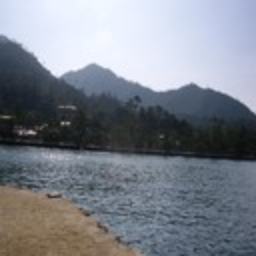

predicted image


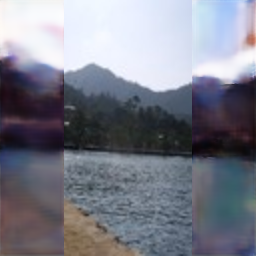

RMSE VALUE: 62.36121840671504


In [ ]:
import cv2
import PIL
url = '/content/gdrive/MyDrive/TE_Mini_Project/WGAN_model/test/test_img_6.png'
"""
file_name = os.path.basename(url)
import urllib.request
_ = urllib.request.urlretrieve(url, file_name)
print("Downloaded image")
"""
file_name=url

image = cv2.imread(file_name)
image = cv2.resize(image, (256,256))
cropped_image = image[:, 65:193]
input_image = cropped_image / 127.5 - 1
input_image = np.expand_dims(input_image, axis=0)
print(input_image.shape)
predicted_image = GEN.predict(input_image)
predicted_image = get_demask_images(input_image, predicted_image)[0]
predicted_image = (predicted_image + 1) * 127.5
predicted_image = predicted_image.astype(np.uint8)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predicted_image = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB)

print('original image')
IPython.display.display(PIL.Image.fromarray(image))
print('predicted image')
IPython.display.display(PIL.Image.fromarray(predicted_image))

image=cv2.resize(image,(128,128))
predicted_image=cv2.resize(predicted_image,(128,128))

M = np.ones((128, 128, 3))
M[:, 32:96:, :] = 0
num_pixels = 128 * 64 * 3 
res= np.sqrt(np.sum(((image- predicted_image) * M) ** 2) / num_pixels)
print("RMSE VALUE:",res-100)


Downloaded image
(1, 256, 128, 3)
original image


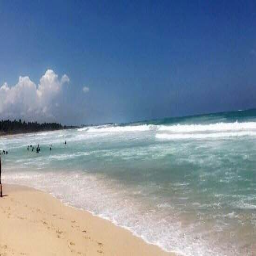

predicted image


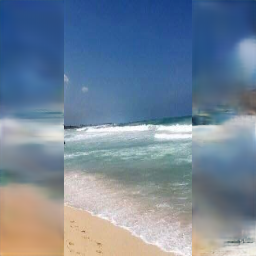

RMSE VALUE: 170.03825654051278


In [ ]:
url = 'https://ak-d.tripcdn.com/images/100s10000000p8lx5C86A.jpg?proc=source%2Ftrip'

file_name = os.path.basename(url)
import urllib.request
_ = urllib.request.urlretrieve(url, file_name)
print("Downloaded image")
#file_name=url

image = cv2.imread(file_name)
image = cv2.resize(image, (256,256))
cropped_image = image[:, 65:193]
input_image = cropped_image / 127.5 - 1
input_image = np.expand_dims(input_image, axis=0)
print(input_image.shape)
predicted_image = GEN.predict(input_image)
predicted_image = get_demask_images(input_image, predicted_image)[0]
predicted_image = (predicted_image + 1) * 127.5
predicted_image = predicted_image.astype(np.uint8)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predicted_image = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB)

print('original image')
IPython.display.display(PIL.Image.fromarray(image))
print('predicted image')
IPython.display.display(PIL.Image.fromarray(predicted_image))

M = np.ones((256, 256, 3))
M[:, 64:192:, :] = 0
num_pixels = 256 * 64 * 3
res= np.sqrt(np.sum(((image- predicted_image) * M) ** 2) / num_pixels)
print("RMSE VALUE:",res)

Downloaded image
(1, 256, 128, 3)
original image


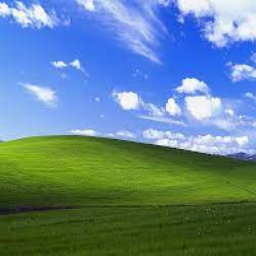

predicted image


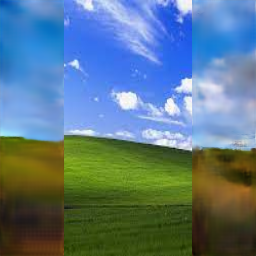

In [ ]:
url = 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBYWFRgVFhYZGRgaGhoZHBoaGhwcHBwaGhgaGhocGR8eIS4lHB4rIRoaJjgmKy8xNTU1GiQ7QDs0Py40NTEBDAwMEA8QHxISHzQnJCs0NDQ2NDE2NDQ0PTQ0NDQ0NDQ0NDE0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NP/AABEIAMkA+gMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAACAwEEBQAGB//EAD4QAAEDAAcFBgUDAgUFAQAAAAEAAhEDBBIhMUFRBWFxkfATgaGxwdEGFCJS4TJikkLxFRZygtIHI1Oi8kP/xAAbAQADAQEBAQEAAAAAAAAAAAAAAQIDBAUGB//EACwRAAICAQMEAAUDBQAAAAAAAAABAhEDEhMhBDFBURUiYXGRBTLxFEKBscH/2gAMAwEAAhEDEQA/APb1n4RoXMNi0x02hN8ftg5ey8yzZNO28ULrQJmIdIuERJ8sytn/ADO6zdjP6TpxUbJ+JP8Auutt+lwujUYC/M4L14PqYRern7nDLak1XBNHUKCmov0sa+76mizfODmzccRvWIzZL2uLXNMNOOEicibjd5r6GBRvaSWghxgyBeVQdSto3WHBwaQQCRI4A+6xx9VNWkn9n/wuWKPDMmi+GLbJa+QRdaGB0MXjReVrlSfRvcx7SHA63EZEagr6bUq2yzFoCLr4HXcqPxHshlM0ONz24O3ZgjMKsPVzjPTPswnhi43HufPCHATF0wiYXG4LXpqsQ1zDEme44/Sd6x2sIkOlrhgF6cJqSOZxaGMeVpbM2g9kgXjffhxWQ+QATN5IwwIxHioZSRmiUFNUxxlTPoOx9oMeJdDXYRPkq+3qOHh7XG8RAm6F42ip78e+VYZW3G60eeK4/wCkcZ6k/wDBtu3Gj0lWrgBsl08sVZprDhay3ZcV5dryTM78Fdq9bc0j6rlM8FcoakXa1VWm46XELArVRcDroV6ljw8XETu9lVrFWkZSjFlcHTCUUzyzQ9p3LSqTg7Eq2arO9UqWqlhnLVdDmp8eSNLQys01ggclRdttzJbdE78N0blbp6QPZYJvyK83X2EGCtMUIy4kiZSa5Ro1/azC2GNLZvcdTCf8M7XApWW3fUbpNwjILzFshWahQh7gPqBnEX90LaeCOhxIjklqPtlFTAgGUQpRqF82pds0lWAZBkgQTfl+EjZnxC5rwXuumTAxleP8Pk05J8eDs30uD6c6mAxVWtU1kgjfMQvKVv4haDg46XeKzj8UCTIOf47/AGUw6Kb5oHmR9CoqxIlM7Ref2LSl7GuDgQfA6LVvXPPHplRSlaLnaIXvVQ0uqFtYGanQOx76RR2gRtow4KflQj5UFM+XEojSmALrsLhmuLUJavpODy0zVqW23j6XPNmON40VuufEZe6A4lhEEOaI98/BeeIQkLB9PjctVGiyySqzcqe0WybTjcLib5GQGveuofiZzGhhl4m8nTRYJCEtTfTQfdWG7Lwble2ux0FokEXjAhZRrV8kTxVUhQVrDFGKpCc2y3Xa5bi6L5u1iFVtIFC0UUlSJcm+WNRtIVe0iD0OI0y7RUhGUqy184tHOFmCkTG0m9ZyhZakbVBTQJbIWjQ7QdneNCsSpv1g7wYWmyyRGfNcmSC8o2jI0mU7TkAprdE0jBZpYZ4cU6r16foceB0O9YODXMS9Xsx6/V4vas63aFh3jktyvsxOB3YFeerDwTfcV34XaMZ8Mz63VyxxBSKN7mmWuIOoJCuUzrVxywKRTUcHdiF1p2qZg+9omuVx9JFt1qyIB3JFG+DjCbSvBygiB4ZpRCqMVVUJvk1atSufAa1zgAGm6c8xmvSUGz2Cjmy2bpbABMxOPfgvIVJwzJkEXTdGfevcbHoKKmaQHuuA3RddC4Oq+TnsjoxPUbWx6Cw1oFwAF15uAuvK2eyBvlZ1CGsaBOAhY1e2lTMfLXBzBfAgE7pXj7cssm0zqtRXJY+I6GktsdRQYgFpukTjuWrU6lcC68wFjUO1Q83CDvWnVtssvbIluKucMiio12EnG7NRjbOSZKxztthNzrwJhK/zNRfcOY91hs5H4NNcfZ4ktQlqcWoS1e8meWKLUJanWVBaqsKEEIC1WCxAWqkwoSWoC1PLUJYmpAIIQkJzmI6WqOa0Oc1wa7AkGDwKepCoqEKITC1RZV2IBEHroQwgLLFHShXqtWRmblkqWkqJQTNIyaPYVZ5LfpeeH6lXrNVDrwQH6Cb+CwKKtvbgVoUW1yRD2gjUXELkeGUXcTVZIvhiaSke36XcFQrLw7Jb7GMpG/Sb9HYrErtDYMELbE03XZkzTozXIc770xyAhdiOewHBBZTYUQqFYEJ1Wpi1whxaJm7zjNBC6ypaTVMadHpajt8NBa/6tD7oK9twUn0CWgZ3XwvPWUdm7K/mFh/TwUtVGm9JqhtJW3GBJgaXHglPpiZAJhQWLg1bKMUQ5M5lK4GQT0IRdo7VWqjV5deY1Go0WyypMgf9nLRZTyRT7FRjJruEWKCxWC1CWLk1FUIsIS1WBIwQlqrUFFctQ2FYc3cgspqQUWqjXAyWvY17SLJuGGNxWjWtvUT2WDQgtwg3G7AgjArFIRsLb7Qnh1isZ4oyepr8M0jNpUgKvWmsdabRtInB31EDSVr1za7KehLHAMdIsjLHGcNVhvYMkstVyxRk1LyiVNrjwJpqEtJBSi1XDheJGR9kgsXRGRDRXLVBanlqEsV2TQmFCaWqLKdgcyjJwBN03X3DEoU0GBcIOsqWFpP1YRlwuU2MW2kIRPrTiIN/FA8JZamophbQqkQQnliGytEyKEwuhbOzPh+np4LGfSZ+txAbI8dMla/yfWoJsNuyttk8L45wspdVii9Lkk/uWsUmrSZ5yF0K3WKo5ji17XNcMQRGOHck2Vqppq0Q00KhWKs8NMlodxwQWUbHRcbwiXKoFwze2ds1lO+08xde1rbrhAvi5aj/AIaqrAHOe4g3XOGOE4JOw65Yo3WGj/VMEngc0uv19hdJgmL4uPnevLluym1FtL6HYlFRtpEbQ+FmgW6OmtDRwE9xEbslnfLVj7X8z7LSqm1GAghtrfMZ6HNaf+ZaP7Hc2+6WvNHhqydONlAsQ2VZLUBahSJoFj8iARwWhQVaheIMtKoWUTXEZqZpvs6Ki67mnS/DrYlj54qi/Yjwruz65ZN5EcFtfNMIkEQuZ5csHT5NlCEvoeHp6q5pggquWL1O1XtfcHGN0eK8/SMIK7MWVyjbMZx0vgqFqgtTy1CWrfUZUIIySyxWCxFRUFp1m0G73XBPVSHpKZYubQlxAAklWHMgkaJ9TpA1wMAnfGOWKHJpWgUVfJRfVYSnUUL3OyaJj5a9rC9xJH0/04icit75Zkg2GyMDZEjguOf6hodOJ0R6fUrs+Tlm5CWL6NtzZVG6je4MaHxIcBBJBmDGM4d68VXKuWOjEZHUe63wdUsq9MynhcTMLEJarrjuSSxdSmZNFc0a0tm7H7V0F7GDWZJOgCPZex6SnJDAPpiXOMATManI4DJWK7UuxdZNoPaL4Nx3ggzeO5ZZMyb0Rl8xcYcamuD2Ox6NlAwUQfaIvJN158grtYrzGNtEwF4XZFTfTUhHaOZdrJJvgaGF6Fnw66+adxBifpEznnmvJzYoRn88ue74OyE5OPyoKlr9HSNdFl4cLLt4OR3Lxm19nNa4uYIab7M4bgcwvXN+EaOZ7R44WQl1rYJcA3OYDzhG8StsGfFjl8r4M8mOUlyjwNhdZXqqx8I0rWl1ppibgTJA0u4rGNQduXpQ6nHP9rOWWKUe6KDSYiblEK98i7RSKqW/qar1x8E6WUQEULbfWaNzbLqJrboBaBdvFyUKiz7z/FRve0VtmyWri1OLEJavP1GtCS1CWp8ISxNMKEQmMpS3oIixAWKuH3BcDH1gHEeipPCcWIS1OKUewPkrlqgtTy1CWrTUKhBahLU8sQlqdhQgtUQrMCIi/WSgLU1IKHbOr7qJwcMJwy39bl6lvxFQkTaM6QcV44tUWVhl6eGR2zSOSUVSPS17bjHthpImcQRzWJ82HCy+CAZE3qsDqJTwKI4h4O6D6hEcUIKkmDm5dy5V6rRUjbJDQ7+lzeMwYVSl2QQ6zIAM2TjJjA4RmrVWpKMERSRAj6mRdxEq8KwS2z2jCN8eSjXKL47fUemL7l/4ZoGsogBZtyQ6Ik/UYm+8aFHtzZzKXIB8QHeMHd7rAo6vSMdbY5s8/DNdTVusTac11wvuNniVhtS3Naka6lp0tHbLAZSX3Q6DdMQb40K9lRvDhIIK8LRVlwd9QxWzUtpFl2IOXsjqcUpu13FiklwelASKwYCqO2ozFt+7BVaztFxEBov34Lljik32NpSVFmsV24tCwaGqFxNlsjDmrJa9wwjcq/yr5zAOY1GYhdeOKgmkzB23bK1eqxYYc0icPwc1nUjpWzXKYvgPMwDeFRpKqwNaQ17sQ4zdOUQJkema6cc6S1dzOUbfBm2Rndv/AApn9xVk1ZuRdy9V3yJ6B910a4+zLS/RvFiEsXUddo3CQ9vOPNLpNoUY/rngCfIQvKl1GOH7pJfdm2kMsQlqq0m12DBjzxges+Cq0m2jkwDi4n0Cwl+pdPH+78cj0M0y1CWrHftekODWcnf8kl206fIN/j+VHxXB7f4DQzcLENhYLto1nVo/2hJftGs/eO5rPUJ/FsP1DbZ6VlVc4wGkph2XSxNg+E8sSvHu2jWvvH8aP/ipbtmuD/8AUn/a30aj4rj8f6KWNHrhsqlN9g+A8zck1moPZ+phG+4jmLl50fFFdb/WDxaT5FDSfGNZP62MPAOB8yrj+pRb5fH2B41XBtFigtWCPi50y6hBP+s/8FYb8ZMiy6g5NaT3G5dK6/E/JO2zXbQk4BC6hcLyDGsXKnVvjSjAgF7Bo5gPkSrtB8WUBM22EnG0HM8wFa6qL7NfkNCFhk4I6OqvcYa0n+8I3bRoqS9jmE/te13lerNVrBZN0gwcYwW27cbiTpV8g/4RSQYAJBggG8ccvFV31J7ZljhGJi7ngtuj2q0OkNdOl0E7xrKutL6QWgyzOpA8r1i881+5Ki9tPseXZRPAtBr7OsGOeChlYe3BxHevSihpmCy8B4dk0ib8ZkCVXc3s/qNDcTEmxlw35prOn4TDba8mK6tFw+oWtCcULabcr9Zo2PNpjS04kNBi84nII27LaSGh18Ak/haLJFLlULRJsz21kgyFPzTltt2IyG2iRdeWuvJ1gggeCbT7OoA2yGmfumXb84PDBZvqMd9h7cvZk1fajm43hXW7Va4Rgd9y6h2RRQbT3TlFkCOF6Oh2FRkS6kzNwsi7LW9TKWJ88/gaUypTVgHCJyMZKuXP1x7wr/8Ah9GHWbcXxJGWRWk3ZDG3ueY3AD3SeWEf4HpkzzrLYi4HODgr3zr/ALRyCOttDHFoMi6DjzhJ+YWlqfNE9uLMUgbz3hA5wGXiq4rPVon1lT2w+7zK/Pqfo1DNIMgOaA0p3dxHooNIdQe4oRSDXrmqv6AQaY6+P4QGlOvgfdMLt/p6pboOfmeStSXoBZO/zSHk6T35qyaMaifFd2Y+7zhaJoZSeepS3D3z91omhGvtySzQjKeXsqU4gUCdCELrXR9lf7HceUoHUA0P8TPgFSmhGe5k4hIfV2rUdQgYeR9kD2a+S0jl9AZD6rpfz90l9XIyC2+z3eaBzBnI7pHOFqszAw30O5Qxjm/ocW8CR5ELZdV9I63XKvS0H7fP1WkcwytRbRrLDLaak/m4jkSQtOrfGm0GXdtaGjqNh8Q0HxWa6r7/ACSzQaQVss8vYHo6L/qLWpBeyifH7XNPO0R4K4P+olu6koIAgiw8O4/S5rR4rxzqPcllgWkeoa7MD6XVvj+qkYPZlL6MHl2bnLRqPxJUXy91Zo7xEPlnf9cQvkBohu8ELmR1+VoupY7PutTrNC8S1zX6FlJaEdxwUWGT+ogd1w718Hczd4KzQbQpmEFlLSNjR7wOUwVrHqV5EfaaWhoxeHk6g2SeIi7uQUzGugNI3mL41IlfIaLblZbEUz7siZx1nHvVh3xPWSINJwIDWEd7QFrHqYeWxUfT+wBBNq8ZR5Kw+ncQGB7SQP02/qjheV8jdtp7gQ57zxfPmEplcbIJ8WzfrdK3WXFLuxUz6k6ieZNwi4y78Kt2T9BzXiG/ETwCBSkaQCcN73COFkpX+Lv/API7+Y9lsssfDRDialsRlzK4EZevnCyjTtzA8AfA3oqOsjK/gT5SvjtpmhrsrAwzwynHLJMNOP3ch7rLFbkQPEedxUGlPDgW+SzeIDVt73fx9io7YanvafP2VDtiMz4H1RNrZnHz9pKnbYFztm6n+Met64vG/keu5Vm1rU+J9UXa6Hru9kaWBZFJ+10brvT1RF4OblT7Y6+Kjt3a89eMpaGBdI/b5+hQNJ3cz6qt8xvB9UbaTWefl0E6a7gPInTn7ErrOseY8koERif4/hcH8O7+6YBvZdMM8R5BAWbhzJ8EQfuPjgocTuvnPLv6vTQA9md3fa8kLqM/tw/cPdObOgnuPqpsndr1FyeqhFJ9CeHeUBoBuPcfZaBDd3XcpsN1nuBwT3GBkPogOneyE1cHLzWy+jbnPiPFL+WGQJ71SyjMZ1UG/lKS+qnQnrit40Bi4HklmiP2+H5VxzMDz5qp3jl6oHVZ29b7qHh3pLmD+39lpHOwMI1coexK2nUY0Sn0TQJN3HBaLMBlNqxz9EQqo1WmashNX4J7tgZ/y4U/LblddQ9So7HcPBPdApNrR9kXzAOIzzjhmVmCm4+KkUvU/lVoKNIU+8HcfTFcKzv8bvJZ4pT16qe03dckbf0CjQdWND6o20wjEncZ371mh+4eHsotnJG0FGqymGp5BGKfie72Hqslruo/C4O6uUvEFG0K2R/9EeiL5vqSscP6hTaPQH91DxIVGsK1w77vJSytcOf9lktJ165orTv29d6W0go121vd1vUivHKeuKxw52oHd+UYecJHM+iW1EKNcV87wN4CkV3eOR15LLEziOu9GGHTx/KTxxCjUZXBoY4QMDjejbWWnLrzWYLWnojbfl1yUOCCjSFaHd3nzlSK4NBpgPxvVBo48iUVoY395KWhBReFedlA7o9FxrTtfL2VMEb/ABRBw7utyWhegplg0ztfA+eC5rycZPL+6QKQdGFIrI15H8o0v0FFlgOg67kRYd3KfVVjWxv5pbq8N464qdEmPSXTQnXr0Q9mOj+FTO0majn+UB2qz728x7qljmKi92Ok9bsELqI9XfhUDtdmb2Hkp/xdoMCTuaLucflUseT0FMuAAYiDvu8cCjs7j4qiNpA32TwLSbtTch+eb9p/i72T25ego8j250TG0xuu8vZXSz9o5BGyjcetO5ei8sfRVoo235AnuPopDX/b13q+KN2vkp7E4Tfdld5Ieb6IeooCjpNBzUto6TcOr1oNYdb/AAiCpsHVRuv0g1FNlC8Zt5fhG2jfm7w/KsmBiR4dBQHt15DPLJLXL6C1CG0L83/+u7/Umtoz95671zqQTgTwGikUn7Xevmk5N/wFhBp+5ykE4Wnc93BCX7jhqFDXTiIwz596kQZP73dxAw3wpLyP63d5/CAHdPM396lztG65XpASXn73dzvwuDj9z+YPouFrTNcAd6XAEun7n/yF3IbkbC7U8/wlDv5/nepLSgBnaOxBd3uJ87t1yg0rpm0RqA5LLV1kA4opBYTnHEudfvOV1340QueM3H+R85UFw5b8M0NsDNviqQB2wLxav/c7/kuNMYzy/rd7pbKYYmTjhdlch7bODyToB3acTz6m5c4iOOoui8EG8nTmdL0WzOCKThcjgLGE/wCnuiDdcoD7sR3dbksTcTwnkoYHExaAExuGpu9E7Aa57hmQc8R3a4gqXPN9/oq9kze5c6NSgBxec3Lu0/cfBJJCi01AD5U2jN0QkmkP2omvOizsdByegiE6lItuyCIPKHYqGnioFGMhuz0Sy46qJOtyXIDhRiJhSQEk8eS6RnJuRYDbs1MDopbXTkiB3DHcgCbV/r5KQ8YoS/guc/ehgEKQ5A9XrhSHTvO7VCKbJQSgAiXbt6m0dQgtDneuAGiACLx9yWb8z1CmyNMFIB64JgCGDUqCwSDfciAMFcaM9d3uiwBLBopcBoM1zWqez61RYEWuCG0dR0UdjLcoDd6doDnXRjrxAunmPBLDhjjuv4JlgA4qRZz66uRaAXZGm7LrJDKZLfJdLcet6dgKM6Lmt1Ce57RJXdoMIRYCiMLr5PK6MuOaiDqE61uXdwRYCnOnNdbC4YjrRCP1c/IqQGWhiuFINFx/Tz80T/bzQMAuOTZ9l1qMlYZl/u80Gff6JIQt1rJS0O16v/Cc7E8PdBm7j6oAEMN4N939+KltEYv60VhuB4KXKbAT2MaKBRXXnqEx3r7oW4c0JgQyijPCVwaMyFJ9FXpvVO7AsBo1UNF/XJczDu9VNHj1qUAc4iFxcdOipOKacRxPkEAVodOHV66HE9df2T6X9J4e6U739E0BHZlRYOqYcOfmhd1yCAFigvJLsPLoplhsb+pUnPrVLf8Aq5eSAOsi7eoLG8uoQN/Ue9dkePomARa0dbvyoIbCWcDx9VzU6AY1+7qVD3xkhpMeS6ky4jyKKA5zzz/KK2hfhzSkUI//2Q=='

file_name = os.path.basename(url)
import urllib.request
_ = urllib.request.urlretrieve(url, file_name)
print("Downloaded image")
# file_name=url

image = cv2.imread(file_name)
image = cv2.resize(image, (256,256))
cropped_image = image[:, 65:193]
input_image = cropped_image / 127.5 - 1
input_image = np.expand_dims(input_image, axis=0)
print(input_image.shape)
predicted_image = GEN.predict(input_image)
predicted_image = get_demask_images(input_image, predicted_image)[0]
predicted_image = (predicted_image + 1) * 127.5
predicted_image = predicted_image.astype(np.uint8)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predicted_image = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB)

print('original image')
IPython.display.display(PIL.Image.fromarray(image))
print('predicted image')
IPython.display.display(PIL.Image.fromarray(predicted_image))

os.remove(file_name)

In [ ]:
import cv2
IMAGE_SZ=128
def postprocess_images_outpainting(img_PATH, img_o_PATH, out_PATH, blend=False): # img, img_0 are (64, 64, 3), mask is (64, 64, 1)
    src = cv2.imread(img_PATH)[:, int(2 * IMAGE_SZ / 8):-int(2 * IMAGE_SZ / 8), :]
    dst = cv2.imread(img_o_PATH)
    if blend:
        mask = np.ones(src.shape, src.dtype) * 255
        center = (int(IMAGE_SZ / 2) - 1, int(IMAGE_SZ / 2) - 1)
        out = cv2.seamlessClone(src, dst, mask, center, cv2.NORMAL_CLONE)
    else:
        out = dst.copy()
        out[:, int(2 * IMAGE_SZ / 8):-int(2 * IMAGE_SZ / 8), :] = src
    cv2.imwrite(out_PATH, out)

(1, 256, 128, 3)
original image


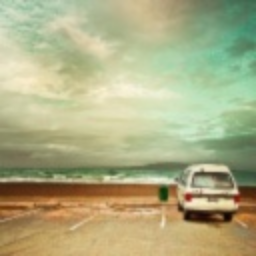

predicted image


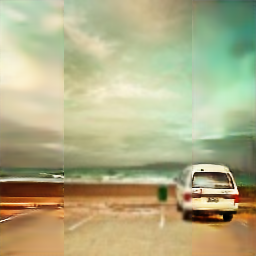

RMSE VALUE: 146.22785720351212


In [ ]:
import extraFunctions
from PIL import Image
"""
url = '/content/gdrive/MyDrive/TE_Mini_Project/images_200/00000029_(4).jpg'

file_name = os.path.basename(url)
import urllib.request
_ = urllib.request.urlretrieve(url, file_name)
print("Downloaded image")
"""
file_name='/content/gdrive/MyDrive/TE_Mini_Project/images_4300/00000029_(4).jpg'

image = cv2.imread(file_name)
cv2.imwrite('/content/gdrive/MyDrive/TE_Mini_Project/img1.png',image)
image = cv2.resize(image, (256,256))
cropped_image = image[:, 65:193]
input_image = cropped_image / 127.5 - 1
input_image = np.expand_dims(input_image, axis=0)
print(input_image.shape)
predicted_image = GEN.predict(input_image)
predicted_image = get_demask_images(input_image, predicted_image)[0]
predicted_image = (predicted_image + 1) * 127.5
predicted_image = predicted_image.astype(np.uint8)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predicted_image = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB)
cv2.imwrite('/content/gdrive/MyDrive/TE_Mini_Project/img2.png',predicted_image)

print('original image')
IPython.display.display(PIL.Image.fromarray(image))
print('predicted image')
IPython.display.display(PIL.Image.fromarray(predicted_image))
image=cv2.resize(image,(128,128))
predicted_image=cv2.resize(predicted_image,(128,128))
out_PATH='/content/gdrive/MyDrive/TE_Mini_Project/test.png'
extraFunctions.save_image(predicted_image, out_PATH)
test_image= Image.open(out_PATH)
cv2.imwrite(out_PATH, np.float32(test_image))
out= '/content/gdrive/MyDrive/TE_Mini_Project/newtest.png'
postprocess_images_outpainting(file_name,out_PATH,out)

im_gt = np.array(Image.open(file_name).convert('RGB')).astype(np.float64)
im_o = np.array(Image.open(out).convert('RGB')).astype(np.float64)
M = np.ones((128, 128, 3))
M[:, 32:96:, :] = 0
num_pixels = 128 * 64 * 3
res= np.sqrt(np.sum(((image- test_image) * M) ** 2) / num_pixels)
print("RMSE VALUE:",res)

Downloaded image
(1, 256, 128, 3)
original image


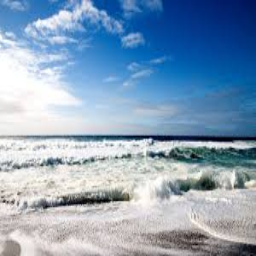

predicted image


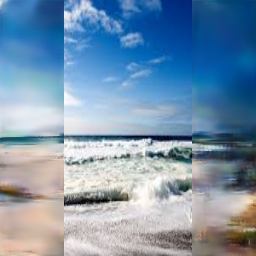

In [ ]:
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSpkX-L9e84gHNpyPwzL1AhQBFmUeQRVZ5e8w&usqp=CAU'

file_name = os.path.basename(url)
import urllib.request
_ = urllib.request.urlretrieve(url, file_name)
print("Downloaded image")
# file_name=url

image = cv2.imread(file_name)
image = cv2.resize(image, (256,256))
cropped_image = image[:, 65:193]
input_image = cropped_image / 127.5 - 1
input_image = np.expand_dims(input_image, axis=0)
print(input_image.shape)
predicted_image = GEN.predict(input_image)
predicted_image = get_demask_images(input_image, predicted_image)[0]
predicted_image = (predicted_image + 1) * 127.5
predicted_image = predicted_image.astype(np.uint8)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predicted_image = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB)

print('original image')
IPython.display.display(PIL.Image.fromarray(image))
print('predicted image')
IPython.display.display(PIL.Image.fromarray(predicted_image))

os.remove(file_name)

Downloaded image
(1, 256, 128, 3)
(256, 256, 3)
original image


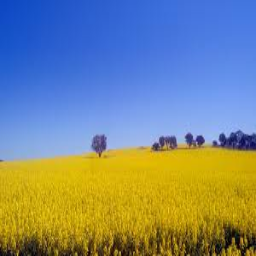

predicted image
(256, 256, 3)


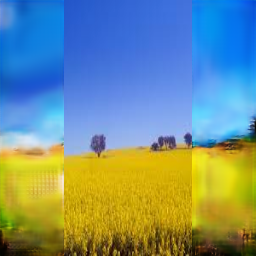

In [ ]:
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRYZ7G557Ohsy4uDSbhyvWgIGLYXyCNCjYbRw&usqp=CAU'

file_name = os.path.basename(url)
import urllib.request
_ = urllib.request.urlretrieve(url, file_name)
print("Downloaded image")
# file_name=url

image = cv2.imread(file_name)
image = cv2.resize(image, (256,256))
cropped_image = image[:, 65:193]
input_image = cropped_image / 127.5 - 1
input_image = np.expand_dims(input_image, axis=0)
print(input_image.shape)
print(image.shape)
predicted_image = GEN.predict(input_image)
predicted_image = get_demask_images(input_image, predicted_image)[0]
predicted_image = (predicted_image + 1) * 127.5
predicted_image = predicted_image.astype(np.uint8)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predicted_image = cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB)

print('original image')
IPython.display.display(PIL.Image.fromarray(image))
print('predicted image')
print(predicted_image.shape)
IPython.display.display(PIL.Image.fromarray(predicted_image))

os.remove(file_name)

In [ ]:
from google.colab import files
files.download("checkpoint/DCRM.hdf5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download("checkpoint/GEN.hdf5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def crop_and_resize_image(img, img_size):
    source_size = img.size
    if source_size == img_size:
        return img
    img = img.resize(img_size)
    return img
def compute_RMSE(image_gt_PATH, image_op_PATH):
    image_gt = PIL.Image.open(image_gt_PATH).convert('RGB')
    image_gt = np.array(crop_and_resize_image(image_gt, (128, 128)))
    image_op = PIL.Image.open(image_op_PATH).convert('RGB')
    image_op = np.array(crop_and_resize_image(image_op, (128, 128))).astype(np.float64)
    assert image_gt.shape == (128, 128, 3)
    assert image_op.shape == (128, 128, 3)
    M = np.ones((128, 128, 3))
    M[:, 32:96:, :] = 0
    num_pixels = 128 * 64 * 3
    return np.sqrt(np.sum(((image_gt - image_op) * M) ** 2) / num_pixels)

In [ ]:
compute_RMSE('/content/gdrive/MyDrive/TE_Mini_Project/WGAN_model/test/test_img_6.png','/content/gdrive/MyDrive/TE_Mini_Project/WGAN_model/test_unblend/out_paste_6.png')

11.19316699172703

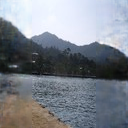

In [ ]:
from PIL import Image
wgan_image=Image.open("/content/gdrive/MyDrive/TE_Mini_Project/WGAN_model/test_unblend/out_paste_6.png")
IPython.display.display(wgan_image)